In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/reg.csv', index_col=[0])
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,Price
0,0.034633,0.206919,0.137057,0.540526,0.193941,0.699239,0.630532,0.239410,0.027375,0.209857,0.347609,0.996394,0.102644,0.422222
1,0.028920,0.014315,0.276113,0.255945,0.618886,0.555407,0.782263,0.482977,0.103031,0.106690,0.520776,0.996650,0.187120,0.368889
2,0.020627,0.033230,0.281116,0.525591,0.165269,0.624102,0.586005,0.272713,0.036010,0.106986,0.595301,0.983284,0.084079,0.660000
3,0.022749,0.033801,0.125044,0.263253,0.251509,0.658532,0.432160,0.344932,0.150018,0.068317,0.651297,0.989989,0.015990,0.631111
4,0.022148,0.029374,0.121057,0.521126,0.399670,0.448086,0.520158,0.495342,0.104383,0.069360,0.560116,0.998723,0.092782,0.693333


In [8]:
X = df.drop('Price', axis=1).to_numpy()
y = df['Price'].to_numpy().reshape((-1, 1))
print(X[:5])
print()
print(y[:5])

[[0.03463293 0.20691874 0.13705684 0.54052579 0.19394064 0.69923874
  0.63053168 0.23941003 0.0273749  0.2098569  0.34760885 0.99639409
  0.10264398]
 [0.02892023 0.01431456 0.27611271 0.25594534 0.61888613 0.555407
  0.7822633  0.48297656 0.10303068 0.10669036 0.52077557 0.99665033
  0.18711954]
 [0.02062738 0.03322998 0.28111574 0.52559077 0.16526854 0.62410153
  0.58600477 0.27271335 0.03600977 0.10698567 0.59530071 0.98328389
  0.0840788 ]
 [0.02274863 0.03380107 0.12504423 0.26325277 0.25150937 0.65853215
  0.43216033 0.34493168 0.15001803 0.06831744 0.65129732 0.98998916
  0.01598962]
 [0.02214811 0.02937355 0.12105722 0.52112605 0.39966963 0.44808566
  0.52015784 0.49534164 0.10438342 0.06935957 0.56011602 0.99872258
  0.09278202]]

[[0.42222222]
 [0.36888889]
 [0.66      ]
 [0.63111111]
 [0.69333333]]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [10]:
class TensorData(Dataset):
    
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len
    
trainsets = TensorData(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)
testsets = TensorData(X_test, y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

In [11]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 50, bias=True)
        self.fc2 = nn.Linear(50, 30, bias=True)
        self.fc3 = nn.Linear(30, 1, bias=True)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        return x

In [12]:
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

In [13]:
loss_ = []
n = len(trainloader)
for epoch in range(400):
    running_loss = 0.0
    for data in trainloader:
        inputs, values = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss_.append(running_loss/n)

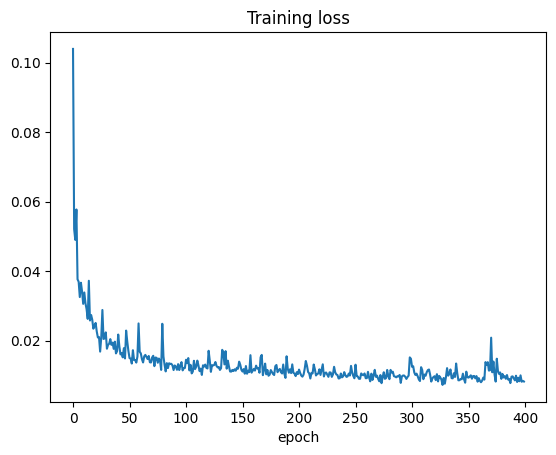

In [14]:
plt.plot(loss_)
plt.title('Training loss')
plt.xlabel('epoch')
plt.show()

In [15]:
def evaluation(dataloader):
    
    predictions = torch.tensor([], dtype=torch.float)
    actual = torch.tensor([], dtype=torch.float)
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)
            predictions = torch.cat((predictions, outputs), 0)
            actual = torch.cat((actual, values), 0)
            
    predictions = predictions.numpy()
    actual = actual.numpy()
    rmse = np.sqrt(mean_squared_error(predictions, actual))
    
    return rmse

In [16]:
train_rmse = evaluation(trainloader)
test_rmse = evaluation(testloader)
print(f'train RMSE: {train_rmse}')
print(f'test RMSE: {test_rmse}')

train RMSE: 0.07548773288726807
test RMSE: 0.10285507142543793
